In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import PIL.Image as Image
import torch.nn as nn
import torchvision
import torch.optim as optim
import sys
from captum.attr import GuidedGradCam
import cv2
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

sys.path.insert(0, '../src')
from bird_dataset import *
from XAI_birds_dataloader import *
from tqdm import tqdm
from models.multi_task_model import *
from XAI_birds_dataloader import *
from XAI_BirdAttribute_dataloader import *

from download import *

import shutil

In [2]:
# download = True
# id = '156fCp5_VvRfnyHSCBCXhInSE9TxEqDaY'
# destination = '../cub.zip'
# if download:
#     download_file_from_google_drive(id, destination)
# # shutil.unpack_archive('../cub.zip', '../CUB_200_2011')

In [3]:
bd = BirdDataset(preload=True, attr_file='attributes')

In [4]:
vgg16 = models.vgg16_bn(pretrained=True)


In [5]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_bird_dataset = Bird_Attribute_Loader(bd, attrs=None, species=True, transform=trans, train=True)
val_bird_dataset = Bird_Attribute_Loader(bd, attrs=None, species=True, transform=trans, train=False, val=True)

In [6]:
model = MultiTaskModel(vgg16, train_bird_dataset)

In [7]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

if torch.cuda.is_available():
    model.cuda()

batch_size = 1
trainloader = DataLoader(train_bird_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_bird_dataset, batch_size=batch_size, shuffle=True)

loss_func = MultiTaskLossWrapper().to(device)
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

cuda:0


In [8]:
# data = train_bird_dataset[0]
# inputs, labels = data['image'].cuda(), torch.LongTensor(data['labels']).cuda()
# outputs =  model(inputs.reshape((1, 3, 224, 224)))

In [9]:
%%time
avg_losses = []
avg_val_losses = []
epochs = 50
print_freq = 100
val_acc = []
if len(train_bird_dataset.class_dict) > 1: plural = 's'
else: plural = ''

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
#         print("LABELS:",data['labels'])
        inputs, labels = data['image'], torch.LongTensor(data[f'label{plural}'])

        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = model(inputs)
        # print('outputs came')
        # print("OUTPUTS:",outputs) 
        # break
        loss = loss_func(outputs, labels)
        # print(loss)
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
#         print('running loss', running_loss)
#         print(outputs)
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            running_loss = 0.0
            
    avg_losses.append(avg_loss)
    
    model.eval()
    with torch.no_grad():
        num_correct=0
        val_losses = []
        data_iter = iter(valloader)
        for val_data in data_iter:
            val_inputs, val_labels = val_data['image'].cuda(), torch.LongTensor(val_data[f'label{plural}']).cuda()
            val_outputs = model(val_inputs)
            opt.zero_grad() #zero the parameter gradients
            val_predicted = [torch.max(i, 1)[1] for i in val_outputs]
            num_correct += sum(np.array(val_labels.cpu())==np.array(val_predicted))
            val_losses.append(loss_func(val_outputs, val_labels).item())
        acc = num_correct/(len(data_iter)*batch_size*len(val_labels))
        val_acc.append(acc)
        print('Validation accuracy:',acc)
        print('Average validation loss:',np.mean(val_losses))
        avg_val_losses.append(np.mean(val_losses))
    model.train()
print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 4.896
[epoch: 0, i:   199] avg mini-batch loss: 4.309
[epoch: 0, i:   299] avg mini-batch loss: 4.024
[epoch: 0, i:   399] avg mini-batch loss: 3.850
[epoch: 0, i:   499] avg mini-batch loss: 3.767
[epoch: 0, i:   599] avg mini-batch loss: 3.565
[epoch: 0, i:   699] avg mini-batch loss: 3.510
[epoch: 0, i:   799] avg mini-batch loss: 3.505
[epoch: 0, i:   899] avg mini-batch loss: 3.353
[epoch: 0, i:   999] avg mini-batch loss: 3.138
[epoch: 0, i:  1099] avg mini-batch loss: 3.074
[epoch: 0, i:  1199] avg mini-batch loss: 3.039
[epoch: 0, i:  1299] avg mini-batch loss: 2.969
Validation accuracy: 0.11730205278592376
Average validation loss: 18.917658803050468
[epoch: 1, i:    99] avg mini-batch loss: 2.979
[epoch: 1, i:   199] avg mini-batch loss: 2.753
[epoch: 1, i:   299] avg mini-batch loss: 2.454
[epoch: 1, i:   399] avg mini-batch loss: 2.826
[epoch: 1, i:   499] avg mini-batch loss: 2.642
[epoch: 1, i:   599] avg mini-batch loss: 2.266
[ep

[epoch: 11, i:   999] avg mini-batch loss: 0.606
[epoch: 11, i:  1099] avg mini-batch loss: 0.451
[epoch: 11, i:  1199] avg mini-batch loss: 0.366
[epoch: 11, i:  1299] avg mini-batch loss: 0.225
Validation accuracy: 0.49853372434017595
Average validation loss: 6.493908861165871
[epoch: 12, i:    99] avg mini-batch loss: 0.227
[epoch: 12, i:   199] avg mini-batch loss: 0.136
[epoch: 12, i:   299] avg mini-batch loss: 0.221
[epoch: 12, i:   399] avg mini-batch loss: 0.301
[epoch: 12, i:   499] avg mini-batch loss: 0.351
[epoch: 12, i:   599] avg mini-batch loss: 0.358
[epoch: 12, i:   699] avg mini-batch loss: 0.162
[epoch: 12, i:   799] avg mini-batch loss: 0.169
[epoch: 12, i:   899] avg mini-batch loss: 0.681
[epoch: 12, i:   999] avg mini-batch loss: 0.709
[epoch: 12, i:  1099] avg mini-batch loss: 0.200
[epoch: 12, i:  1199] avg mini-batch loss: 0.413
[epoch: 12, i:  1299] avg mini-batch loss: 0.323
Validation accuracy: 0.5249266862170088
Average validation loss: 5.924577080958749


[epoch: 23, i:    99] avg mini-batch loss: 0.049
[epoch: 23, i:   199] avg mini-batch loss: 0.008
[epoch: 23, i:   299] avg mini-batch loss: 0.008
[epoch: 23, i:   399] avg mini-batch loss: 0.003
[epoch: 23, i:   499] avg mini-batch loss: 0.005
[epoch: 23, i:   599] avg mini-batch loss: 0.171
[epoch: 23, i:   699] avg mini-batch loss: 0.030
[epoch: 23, i:   799] avg mini-batch loss: 0.013
[epoch: 23, i:   899] avg mini-batch loss: 0.023
[epoch: 23, i:   999] avg mini-batch loss: 0.005
[epoch: 23, i:  1099] avg mini-batch loss: 0.008
[epoch: 23, i:  1199] avg mini-batch loss: 0.008
[epoch: 23, i:  1299] avg mini-batch loss: 0.005
Validation accuracy: 0.7008797653958945
Average validation loss: 3.80744770614982
[epoch: 24, i:    99] avg mini-batch loss: 0.197
[epoch: 24, i:   199] avg mini-batch loss: 0.014
[epoch: 24, i:   299] avg mini-batch loss: 0.009
[epoch: 24, i:   399] avg mini-batch loss: 0.009
[epoch: 24, i:   499] avg mini-batch loss: 0.014
[epoch: 24, i:   599] avg mini-batch

[epoch: 34, i:   699] avg mini-batch loss: 0.000
[epoch: 34, i:   799] avg mini-batch loss: 0.000
[epoch: 34, i:   899] avg mini-batch loss: 0.000
[epoch: 34, i:   999] avg mini-batch loss: 0.000
[epoch: 34, i:  1099] avg mini-batch loss: 0.000
[epoch: 34, i:  1199] avg mini-batch loss: 0.000
[epoch: 34, i:  1299] avg mini-batch loss: 0.001
Validation accuracy: 0.7683284457478006
Average validation loss: 4.647728608150985
[epoch: 35, i:    99] avg mini-batch loss: 0.000
[epoch: 35, i:   199] avg mini-batch loss: 0.001
[epoch: 35, i:   299] avg mini-batch loss: 0.000
[epoch: 35, i:   399] avg mini-batch loss: 0.000
[epoch: 35, i:   499] avg mini-batch loss: 0.000
[epoch: 35, i:   599] avg mini-batch loss: 0.000
[epoch: 35, i:   699] avg mini-batch loss: 0.000
[epoch: 35, i:   799] avg mini-batch loss: 0.000
[epoch: 35, i:   899] avg mini-batch loss: 0.000
[epoch: 35, i:   999] avg mini-batch loss: 0.000
[epoch: 35, i:  1099] avg mini-batch loss: 0.000
[epoch: 35, i:  1199] avg mini-batc

[epoch: 45, i:  1299] avg mini-batch loss: 0.000
Validation accuracy: 0.7624633431085044
Average validation loss: 4.870775330451227
[epoch: 46, i:    99] avg mini-batch loss: 0.000
[epoch: 46, i:   199] avg mini-batch loss: 0.000
[epoch: 46, i:   299] avg mini-batch loss: 0.000
[epoch: 46, i:   399] avg mini-batch loss: 0.000
[epoch: 46, i:   499] avg mini-batch loss: 0.000
[epoch: 46, i:   599] avg mini-batch loss: 0.000
[epoch: 46, i:   699] avg mini-batch loss: 0.000
[epoch: 46, i:   799] avg mini-batch loss: 0.000
[epoch: 46, i:   899] avg mini-batch loss: 0.000
[epoch: 46, i:   999] avg mini-batch loss: 0.000
[epoch: 46, i:  1099] avg mini-batch loss: 0.000
[epoch: 46, i:  1199] avg mini-batch loss: 0.000
[epoch: 46, i:  1299] avg mini-batch loss: 0.000
Validation accuracy: 0.7565982404692082
Average validation loss: 6.2466838129105104
[epoch: 47, i:    99] avg mini-batch loss: 0.000
[epoch: 47, i:   199] avg mini-batch loss: 0.000
[epoch: 47, i:   299] avg mini-batch loss: 0.000


In [10]:
f_label_size = 15
f_title_size = 18
f_ticks_size = 12

In [11]:
task_str = '__'.join(list(train_bird_dataset.class_dict.keys()))

In [12]:
def plot_train_val_loss(avg_losses, avg_val_losses, f_label_size=15, f_title_size=18, f_ticks_size=12):
    plt.plot(avg_losses)
    plt.plot(avg_val_losses)
    plt.xlabel('Epochs', fontsize=f_label_size)
    plt.ylabel('Loss', fontsize=f_label_size)
    plt.title('Training and Validation Loss')
    plt.legend(['Training Loss', 'Validation Loss']);
    plt.savefig(f'../figures/{task_str}_{epochs}_epoch_train_val_loss.png', dpi=800)

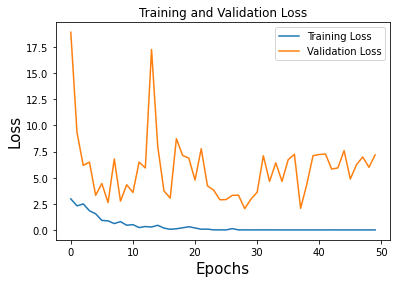

In [13]:
plot_train_val_loss(avg_losses, avg_val_losses)

In [14]:
task_str = '__'.join(list(train_bird_dataset.class_dict.keys()))

In [15]:
torch.save(model.state_dict(), f'../models/{task_str}_{epochs}_epoch_state_dict.pth')